In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Taming time series

Time series are collections of points collected at successive times, usually with equal time intervals between them.

## Importing and visualising Time Series data

In this module, we will consider the "bikes" dataset again but this time taking a time-series perspective. 

* Load the data `bikes.csv`
* Specify that you want to parse the column `'dates'` as dates using `parse_dates=['dates']` and
* Use the dates as the index column

Check with `.head()` that everything is fine then
* Display the temperature time series (you can either use `pandas` plotting facility by doing `bikes.plot(...)` or use `matplotlib` directly)

In [2]:
bikes = pd.read_csv('data/bikes.csv', parse_dates=['date'], index_col='date')
bikes.head()

,temperature,humidity,windspeed,count
date,,,,
2011-01-03,2.716070,45.715346,21.414957,120.0
2011-01-04,2.896673,54.267219,15.136882,108.0
2011-01-05,4.235654,45.697702,17.034578,82.0
2011-01-06,3.112643,50.237349,10.091568,88.0
2011-01-07,2.723918,49.144928,15.738204,148.0


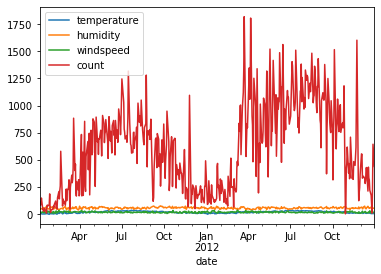

In [3]:
bikes.plot()

### Exercise: only plot the temperature
With the graph above it's hard to get an indication for the temperature in the data. Plot a graph with just the temperature as y-axis.

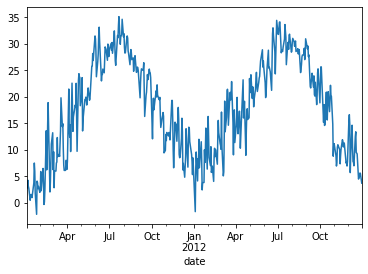

In [5]:
bikes['temperature'].plot()

### Exercise: Number of bikes in a given month

From the chart above, you can see that the data covers two years and that there is a similar pattern in both years which is to be expected for the temperatures. 

The data can be queried according to dates. For example, you can aggregate the data from just January 2012 and check the sum of bikes hired that month. Can you compare that with the number of bikes hired in August? 

In [7]:
jan_start = pd.Timestamp("1st January 2012")
jan_end = pd.Timestamp("31st January 2012")
bikes_jan = bikes[jan_start:jan_end]['count'].sum()
aug_start = pd.Timestamp("1st August 2012")
aug_end = pd.Timestamp("31st August 2012")
bikes_aug = bikes[aug_start:aug_end]['count'].sum()

print("{0:.0f} bikes in January vs {1:.0f} bikes in August.".format(bikes_jan, bikes_aug))

5939 bikes in January vs 37025 bikes in August.


## Resampling

We can aggregate time series by resampling the points on a coarser time level. 

* Use the `.resample` to get the data corresponding to monthly averages
* Display the `temperature` time series for the monthly averages. 

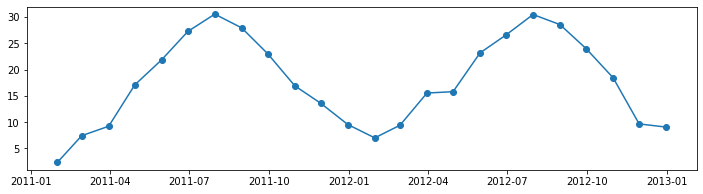

In [8]:
bikes_monthly = bikes.resample('M').mean()

plt.figure(figsize=(12, 3))
plt.plot(bikes_monthly.temperature, "-o")

### Resample by the mean of each week and uses the humidity

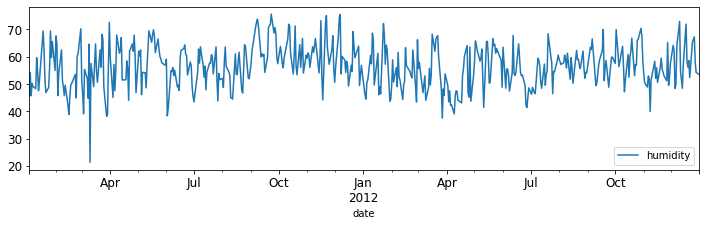

In [12]:
bikes_weeks = bikes.resample('W').mean()
bikes.plot(y='humidity', figsize=(12, 3), fontsize=12)

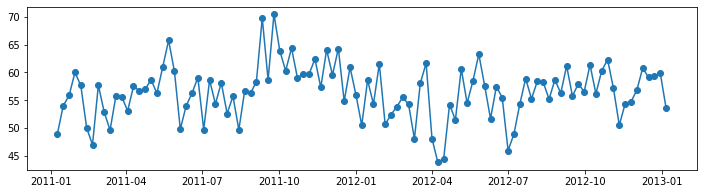

In [13]:
plt.figure(figsize=(12, 3))
plt.plot(bikes_weeks.humidity, "-o")

## Parsing custom date formats

When you loaded the bikes dataset, Pandas automatically detected the format of the dates for you.
This might often "just work" but there often will be cases where you need to be careful about parsing and might have to do it yourself.

Load the data `NZAlcoholConsumption` and have a look at it without specifying a column to parse for dates. 

In [14]:
alcohol_consumption = pd.read_csv('data/NZAlcoholConsumption.csv')
alcohol_consumption.head()

,DATE,TotalBeer,TotalSpirits,TotalWine
0,2004Q3,3.135,1.746,2.318
1,2000Q1,2.957,1.097,1.486
2,2006Q1,3.027,1.443,2.141
3,2000Q3,2.798,1.496,1.844
4,2011Q3,2.865,2.482,2.704


This dataset contains data aggregated by quarters, the timestamp is formatted in a string where the first 4 characters represent the year and the last two the quarter. 
To transform the timestamps in dates that pandas can directly use, you can write a parser function. 


### Exercise: parsing quarter
Write a function `parse_quarter` that takes a string of the form `YYYYQN` and convert it to `pandas.Timestamp` object. Use the following conversion for the quarters:

* Q1 --> mar 31
* Q2 --> jun 30
* Q3 --> sep 20
* Q4 --> dec 31

In [21]:
?pd.Timestamp

In [26]:
def parse_quarter(date_text):
    months=[0,3,6,9,12]
    days=[0,31,30,20,31]
    date_year = int(date_text[0:4])
    date_qtr = int(date_text[-1])
    # print(date_year)
    # print(date_qtr)
    return pd.Timestamp(year=date_year, month=months[date_qtr], day=days[date_qtr])
parse_quarter('2000Q3')

Timestamp('2000-09-20 00:00:00')

In [27]:
import re
# Check that it works!
print(parse_quarter("2000Q3")) # should show 2000-09-20 00:00:00

2000-09-20 00:00:00


### Giving the parser to pandas

Pandas can parse dates using a custom made parser such as the one you just defined. For this just specify your function in the `date_parser` option.

In [28]:
# reload the data using your parser, set the index to the date 
alcohol_consumption = pd.read_csv('data/NZAlcoholConsumption.csv', 
                                  parse_dates=['DATE'], 
                                  date_parser=parse_quarter,
                                  index_col='DATE')
alcohol_consumption.sort_index(inplace=True)
alcohol_consumption.head()

,TotalBeer,TotalSpirits,TotalWine
DATE,,,
2000-03-31,2.957,1.097,1.486
2000-06-30,2.823,1.309,1.915
2000-09-20,2.798,1.496,1.844
2000-12-31,3.997,1.810,2.808
2001-03-31,3.037,1.240,1.287


### Exercise: Display the time series

Now, have a look at the consumtion of wine and beer, show both on the same figure. Discuss the two time series.

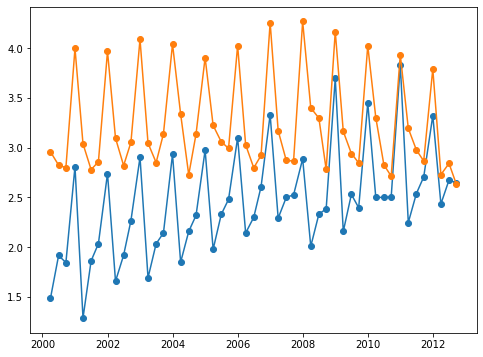

In [29]:
plt.figure(figsize=(8,6))
plt.plot(alcohol_consumption.TotalWine, '-o', label='Wine')
plt.plot(alcohol_consumption.TotalBeer, '-o', label='Beer')

The plots show that the two time series have similar patterns in terms of seasonality but different trends.
Both show that alcohol consumption is maximum in the last quarter of the year and is usually at its lowest in the second quarter. 
The average beer consumption seems stable during the years, while the wine consumption seems to be steadily increasing. 

### Exercise: resample the data per year (12 months) 
Can you resample the data per year (12 months) and see whether the trends come out better? 

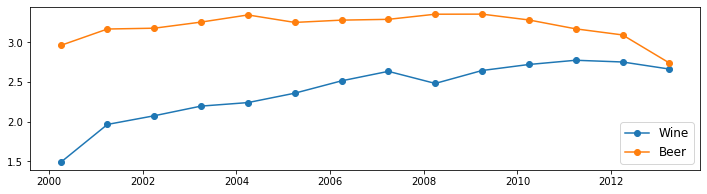

In [32]:
alc_yearly = alcohol_consumption.resample('12M').mean()

plt.figure(figsize=(12, 3))
plt.plot(alc_yearly.TotalWine, "-o", label="Wine")
plt.plot(alc_yearly.TotalBeer, "-o", label="Beer")
plt.legend(fontsize=12)

## Moving Windows

In the cells below you will explore the effect of applying a "Rolling Average" to the data i.e.: look at a number of successive points, take the average, and replace the window by the average (either at the extreme right of the window, or at the center)

* Use the `rolling` method from `pd.Series` ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.rolling.html#pandas.Series.rolling))
* specify a window of 4 points

plot the averaged line and the original time series and discuss. 

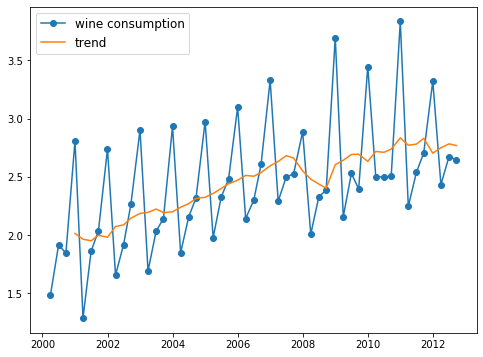

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(alcohol_consumption.TotalWine,
         '-o', label='wine consumption')
rolling_mean = alcohol_consumption.TotalWine.rolling(window=4).mean()
plt.plot(rolling_mean, label='trend')
plt.legend(fontsize=12);

The rolling mean curve seems to capture the trend nicely and removes much of the seasonal movements. 
This curves allows to better appreciate the overall increase of wine consumption over time as well as the dip in consumption in 2008. 

To explore this rolling average further, it's nice to look at widgets. Have alook at the cell below and modify at will. 

In [36]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def rolling_avg_plot(window_size):
    plt.plot(alcohol_consumption.TotalWine, 
             '-o', label='wine consumption')
    rolling = alcohol_consumption.TotalWine.rolling(window=window_size).mean()
    plt.plot(rolling, label='trend')
    plt.legend();
    plt.show()

interact(rolling_avg_plot, window_size=(0, 10));

interactive(children=(IntSlider(value=5, description='window_size', max=10), Output()), _dom_classes=('widget-…

### Exercise: plot the moving sum with a window of width 4

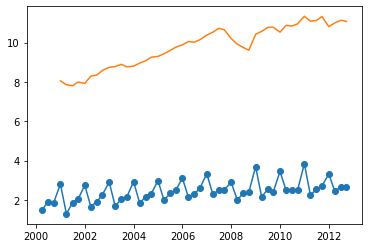

In [37]:
plt.plot(alcohol_consumption.TotalWine,
         '-o', label='wine consumption')
rolling_mean = alcohol_consumption.TotalWine.rolling(window=4).sum()
plt.plot(rolling_mean, label='trend')

## Differencing

Differencing amounts to looking at the time series formed of differences between values separated by a given lag: 

$y'_t = y_t-y_{t-1}$

for a lag of 1. Show the time series for `TotalWine` and the differenced one (with lag 1). What do you observe? 

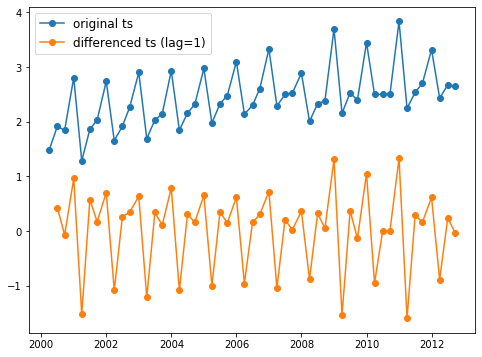

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(alcohol_consumption.TotalWine, '-o', 
         label="original ts")
plt.plot(alcohol_consumption.TotalWine.diff(1), '-o', 
         label="differenced ts (lag=1)")
plt.legend(fontsize=12)

To get a feel for what a good lag should be (though here, intuitively, you should realise that a lag of `4` is a good idea), you can look at the cell below that shows differenced series for increasing lags. 

In [38]:
def differencing_plot(d):
    differenced_ts = alcohol_consumption.TotalWine.diff(d)
    plt.plot(differenced_ts, '-o')
    plt.show()

interact(differencing_plot, d=(1, 10));

interactive(children=(IntSlider(value=5, description='d', max=10, min=1), Output()), _dom_classes=('widget-int…

## Autocorrelation

Autocorrelation measures the correlation (similarity) between the time series and a lagged version of itself. 

* Use the `autocorr` method ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.autocorr.html)) to compute the autocorrelation for lag from 1 to 13
* Display the values of the autocorrelation using a stem plot (`plt.stem`) 

What do you observe? 

<ipython-input-39-9f54ac5aa4bf>:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(lags, autocorrs)


Text(0, 0.5, 'Autocorrelation')

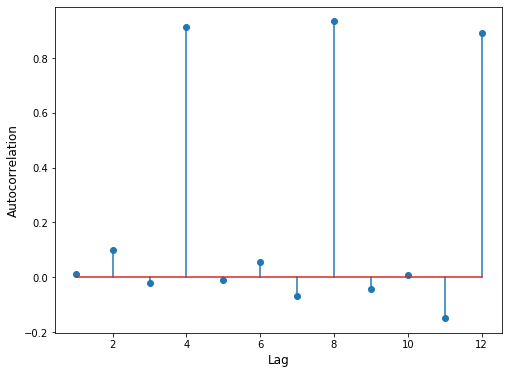

In [39]:
lags = range(1, 13)
autocorrs = [alcohol_consumption.TotalWine.autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(8, 6))
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)

It's quite clear from this plot that the time series is self-similar to itself with a lag of 4 and consistently so (so also with a lag of 8, 12, etc)